# Challenge: make your own regression model

Unit 2: Lesson 4: 2

[Download the Excel file here](https://ucr.fbi.gov/crime-in-the-u.s/2013/crime-in-the-u.s.-2013/tables/table-8/table-8-state-cuts/table_8_offenses_known_to_law_enforcement_new_york_by_city_2013.xls) on crime data in New York State in 2013, provided by the FBI: UCR ([Thinkful mirror](https://raw.githubusercontent.com/Thinkful-Ed/data-201-resources/master/New_York_offenses/NEW_YORK-Offenses_Known_to_Law_Enforcement_by_City_2013%20-%2013tbl8ny.csv)).

Using this data, build a regression model to predict property crimes. You can use the features you prepared in the previous assignment, new features of your own choosing, or a combination. The goal here is prediction rather than understanding mechanisms, so the focus is on creating a model that explains a lot of variance.

In [56]:
import seaborn as sns
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from sklearn import linear_model
%matplotlib inline
pd.options.display.float_format = '{:.3f}'.format

In [94]:
crime = pd.read_excel('crime_NYC.xls', header=None)

# First 4 lines are descriptions
crime.drop(crime.index[0:4], inplace=True)

# Now set first row to column headers and drop that row
crime.columns = crime.iloc[0]
crime.drop(crime.index[0], inplace=True)

In [95]:
crime.head()

4,City,Population,Violent crime,Murder and nonnegligent manslaughter,Rape (revised definition)1,Rape (legacy definition)2,Robbery,Aggravated assault,Property crime,Burglary,Larceny- theft,Motor vehicle theft,Arson3
5,Adams Village,1861,0,0,NaN,0,0,0,12,2,10,0,0
6,Addison Town and Village,2577,3,0,NaN,0,0,3,24,3,20,1,0
7,Akron Village,2846,3,0,NaN,0,0,3,16,1,15,0,0
8,Albany,97956,791,8,NaN,30,227,526,4090,705,3243,142,NaN
9,Albion Village,6388,23,0,NaN,3,4,16,223,53,165,5,NaN


In [96]:
columnlist = crime.columns
print(columnlist)

Index(['City', 'Population', 'Violent\ncrime',
       'Murder and\nnonnegligent\nmanslaughter',
       'Rape\n(revised\ndefinition)1', 'Rape\n(legacy\ndefinition)2',
       'Robbery', 'Aggravated\nassault', 'Property\ncrime', 'Burglary',
       'Larceny-\ntheft', 'Motor\nvehicle\ntheft', 'Arson3'],
      dtype='object', name=4)


In [97]:
# Rename murder column
crime.rename(columns={'Murder and\nnonnegligent\nmanslaughter':'Murder', 'Property\ncrime': 'PropertyCrime'}, inplace=True)

crime.columns
print(crime['Murder'].isnull().sum())
print(crime['Robbery'].isnull().sum())
print(crime['PropertyCrime'].isnull().sum())

3
3
3


In [98]:
# Drop NaN - might be all three if I'm lucky
crime.dropna(subset=['PropertyCrime'], inplace=True)
print(crime['Murder'].isnull().sum())
print(crime['Robbery'].isnull().sum())
print(crime['PropertyCrime'].isnull().sum())

0
0
0


In [99]:
# Robbery and Murder are currently continuous variables.  
# Rework murder and robbery into dummies (values greater than 0 are coded 1)
# Going to loose NaN for 0 here... not sure how to fix this? Can drop NaN beforehand
crime['Robbery_dummy'] = crime['Robbery'].apply(lambda x: 1 if x>0 else 0)
print(crime['Robbery_dummy'].isnull().sum())
crime['Murder_dummy'] = crime['Robbery'].apply(lambda x: 1 if x>0 else 0)
print(crime['Murder_dummy'].isnull().sum())

# Population squared
crime['Pop2'] = crime['Population']*crime['Population']

0
0


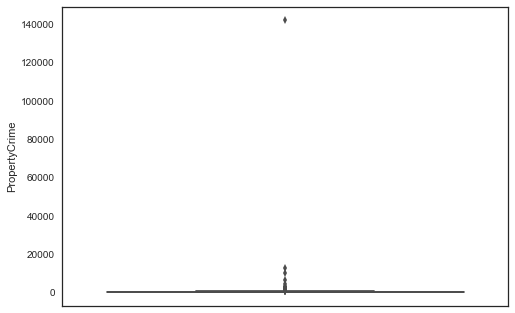

In [63]:
# Looking for outliers
sns.set(style='white')
sns.boxplot(y='PropertyCrime', data=crime)
plt.show()

In [64]:
# There's only one place big enough for that kind of outlier
crime.loc[crime['PropertyCrime']>120000,:]

4,City,Population,Violent crime,Murder,Rape (revised definition)1,Rape (legacy definition)2,Robbery,Aggravated assault,PropertyCrime,Burglary,Larceny- theft,Motor vehicle theft,Arson3,Robbery_dummy,Murder_dummy,Pop2
221,New York,8396126,52384,335,NaN,1112,19170,31767,141971,16606,117931,7434,NaN,1,1,70494931807876


**NYC will definitely affect the regression models**

The best way to deal with this is to rework all the variables into crimes per capita. Here this isn't possible as the model explicitly wants to include population (and population squared, which will give it even more weight!).

New model will look as follows:


$$ PropertyCrimePerCapita = \alpha + \beta_1MurderPerCapita + \beta_2RobberyPerCapita$$

Instead of a true per person measured, I will use crime per 100,000 people instead

In [100]:
# Transforming the variables
crime['PropertyCrimePerCapita']=crime['PropertyCrime']/crime['Population']*100000
crime['MurderPerCapita']=crime['Murder']/crime['Population']*100000
crime['RobberyPerCapita']=crime['Robbery']/crime['Population']*100000

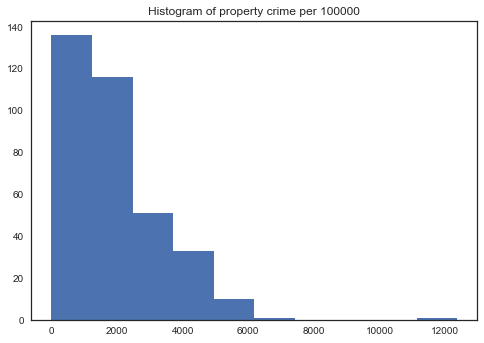

TypeError: No loop matching the specified signature and casting
was found for ufunc svd_n_s

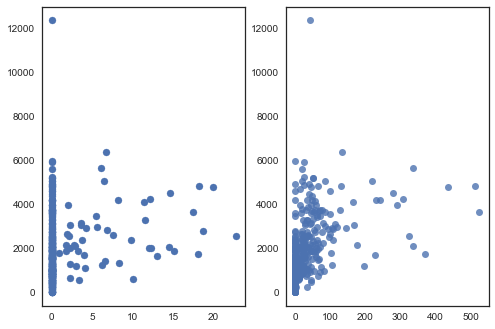

In [101]:
plt.hist(crime['PropertyCrimePerCapita'])
plt.title('Histogram of property crime per 100000')
plt.show()

# A quick scatterplot before we go

plt.subplot(121)
plt.scatter(x=crime['MurderPerCapita'],y=crime['PropertyCrimePerCapita'])
plt.subplot(122)
sns.regplot(x=crime['RobberyPerCapita'],y=crime['PropertyCrimePerCapita'])
plt.show()

So even adjusting for population NYC is still an outlier. The effect of population on crime may itself not be linear (as suggested by the initial scoping of the model).

In [80]:
# Building OLS
X = crime.iloc[:,-3:]
Y = crime['PropertyCrimePerCapita']
ls = linear_model.LinearRegression()
ls.fit(X,Y)
y_hat = ls.predict(X)
r2 = ls.score(X,Y)
print(r2)


1.0


Something isn't working here. Not often I'm upset about a high R2...

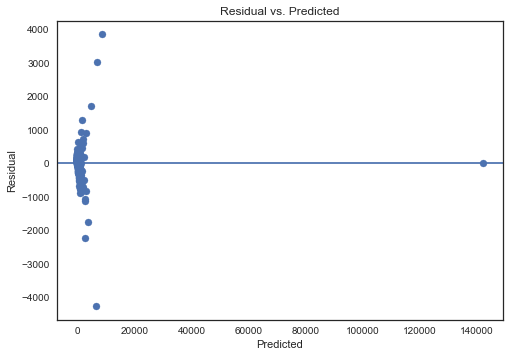

In [103]:
residual = Y - y_hat
plt.scatter(y_hat, residual)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()

# Using the original suggested model without crime in NYC

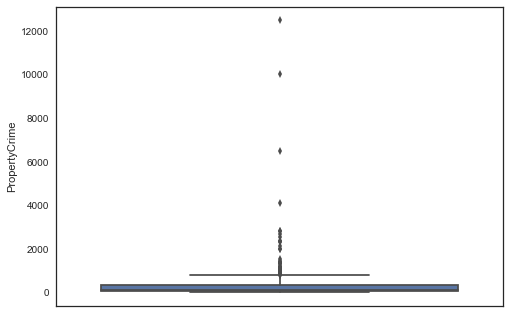

In [85]:
crimelessNYC = crime.loc[crime['City'] != 'New York', :]

# New distribution

sns.set(style='white')
sns.boxplot(y='PropertyCrime', data=crimelessNYC)
plt.show()

Note the change in y axes from (0:140,000) to (0:12,000)

In [104]:
# Building OLS
X = crimelessNYC.loc[:,['Population', 'Pop2','Murder_dummy','Robbery_dummy']]
Y = crimelessNYC['PropertyCrime']
ls = linear_model.LinearRegression()
ls.fit(X,Y)
y_hat = ls.predict(X)
r2 = ls.score(X,Y)
print(r2)

0.841549137196


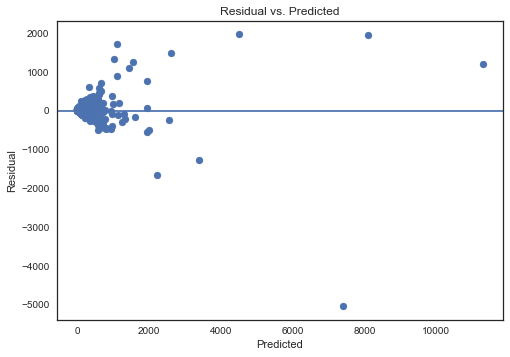

In [105]:
residual = Y - y_hat
plt.scatter(y_hat, residual)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()

Some heteroskedasticity as variance increases in y_hat size. Even with the Pop2 it's not catching the full effect of larger cities/ density/ high population on crime.

# Using the original suggested model with crime in NYC

In [91]:
# Building OLS
X = crime.loc[:,['Population', 'Pop2','Murder_dummy','Robbery_dummy']]
Y = crime['PropertyCrime']
ls = linear_model.LinearRegression()
ls.fit(X,Y)
y_hat = ls.predict(X)
r2 = ls.score(X,Y)
print(r2)

0.996124371124


Explaining NYC observation outweighs everything else...

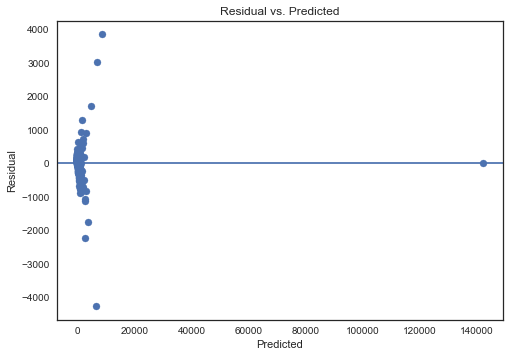

In [93]:
residual = Y - y_hat
plt.scatter(y_hat, residual)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()